# RTP Forecasting

In [1]:
import argparse
import os
import random
import numpy as np
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt

import sys 
import scipy.io
import math
from datetime import date       

import imageio

import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Lambda, LSTM
from tensorflow.keras.layers import concatenate, Input, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-11-15 08:15:19.310583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [38]:
# Plot history and future
def plot_predictions(pred , actual, title):
    plt.figure(figsize=(20, 4), dpi=150)
    plt.plot(np.arange(len(pred)), np.array(pred),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred)), np.array(actual),label='PF', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', lw=1, alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('Price' , fontsize=18)
    plt.title(title, fontsize=16)

In [12]:
#zones = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'HUD VL', 'LONGIL',
#         'MHK VL', 'MILLWD', 'N.Y.C.', 'NORTH', 'WEST']
zone = 'N.Y.C.'
year = 2021

### Data Import

In [13]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [15]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [10]:
raw_data

,DAP,LF,OT
date,,,
2017-01-01 05:00:00+00:00,33.60,5065,32.28
2017-01-01 06:00:00+00:00,32.05,4934,30.77
2017-01-01 07:00:00+00:00,29.23,4812,31.17
2017-01-01 08:00:00+00:00,25.02,4728,32.00
2017-01-01 09:00:00+00:00,26.94,4665,27.89
...,...,...,...
2022-01-01 00:00:00+00:00,33.49,5362,30.21
2022-01-01 01:00:00+00:00,31.28,5139,30.23
2022-01-01 02:00:00+00:00,30.49,4943,30.34


In [17]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

In [18]:
log_data

,DAP,LF,RTP
date,,,
2017-01-01 05:00:00+00:00,3.361417,5065,5.143475
2017-01-01 06:00:00+00:00,3.306154,4934,5.134621
2017-01-01 07:00:00+00:00,3.197039,4812,5.136974
2017-01-01 08:00:00+00:00,3.008155,4728,5.141839
2017-01-01 09:00:00+00:00,3.098740,4665,5.117515
...,...,...,...
2022-01-01 00:00:00+00:00,3.357594,5362,5.131318
2022-01-01 01:00:00+00:00,3.277522,5139,5.131436
2022-01-01 02:00:00+00:00,3.247269,4943,5.132086


### Data Preprocessing

In [19]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [20]:
# # Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


### Reshape to (samples, steps, features)

In [21]:
n_steps_in = 24
n_steps_out = 24

x_train_lstm = np.array([x_train[i:i+n_steps_in] for i in range(0, x_train.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape,y_train_lstm.shape,x_test_lstm.shape,y_test_lstm.shape)

(35017, 24, 3) (35017, 24, 1) (8713, 24, 3) (8713, 24, 1)


In [22]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [23]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train_lstm.shape[-2],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 56,152
Trainable params: 56,152
Non-trainable params: 0
_________________________________________________________________


In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(x_train_lstm, y_train_lstm, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
438/438 [==============================] - 9s 16ms/step - loss: 3.0078 - val_loss: 0.2697
Epoch 2/50
438/438 [==============================] - 7s 16ms/step - loss: 0.7944 - val_loss: 0.2396
Epoch 3/50
438/438 [==============================] - 7s 16ms/step - loss: 0.7751 - val_loss: 0.2303
Epoch 4/50
438/438 [==============================] - 7s 16ms/step - loss: 0.7215 - val_loss: 0.2175
Epoch 5/50
438/438 [==============================] - 7s 16ms/step - loss: 0.7036 - val_loss: 0.2118
Epoch 6/50
438/438 [==============================] - 7s 16ms/step - loss: 0.7320 - val_loss: 0.2032
Epoch 7/50
438/438 [==============================] - 8s 17ms/step - loss: 0.6361 - val_loss: 0.2041
Epoch 8/50
438/438 [==============================] - 7s 15ms/step - loss: 0.6731 - val_loss: 0.1986
Epoch 9/50
438/438 [==============================] - 7s 16ms/step - loss: 0.6236 - val_loss: 0.2012
Epoch 10/50
438/438 [==============================] - 7s 16ms/step - loss: 0.6374 - val_lo

In [25]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [26]:
lstm_model.save(os.path.join(model_path,'LSTM_model.h5'))

### Evaluate

In [27]:
# reload the saved model
lstm_model = load_model(os.path.join(model_path,'LSTM_model.h5'))

y_test_pred = lstm_model.predict(x_test_lstm)


273/273 [==============================] - 1s 4ms/step


In [28]:
y_test_lstm.shape

(8713, 24, 1)

In [29]:
y_test_pred.shape

(8713, 24)

In [35]:
# Evaluation metrics
errors = y_test_pred - y_test_lstm[:,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4542
RMSE: 0.7047


In [36]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred[::24,:] - y_test_lstm[::24,:,0]
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

MAE: 0.4726
RMSE: 0.7172


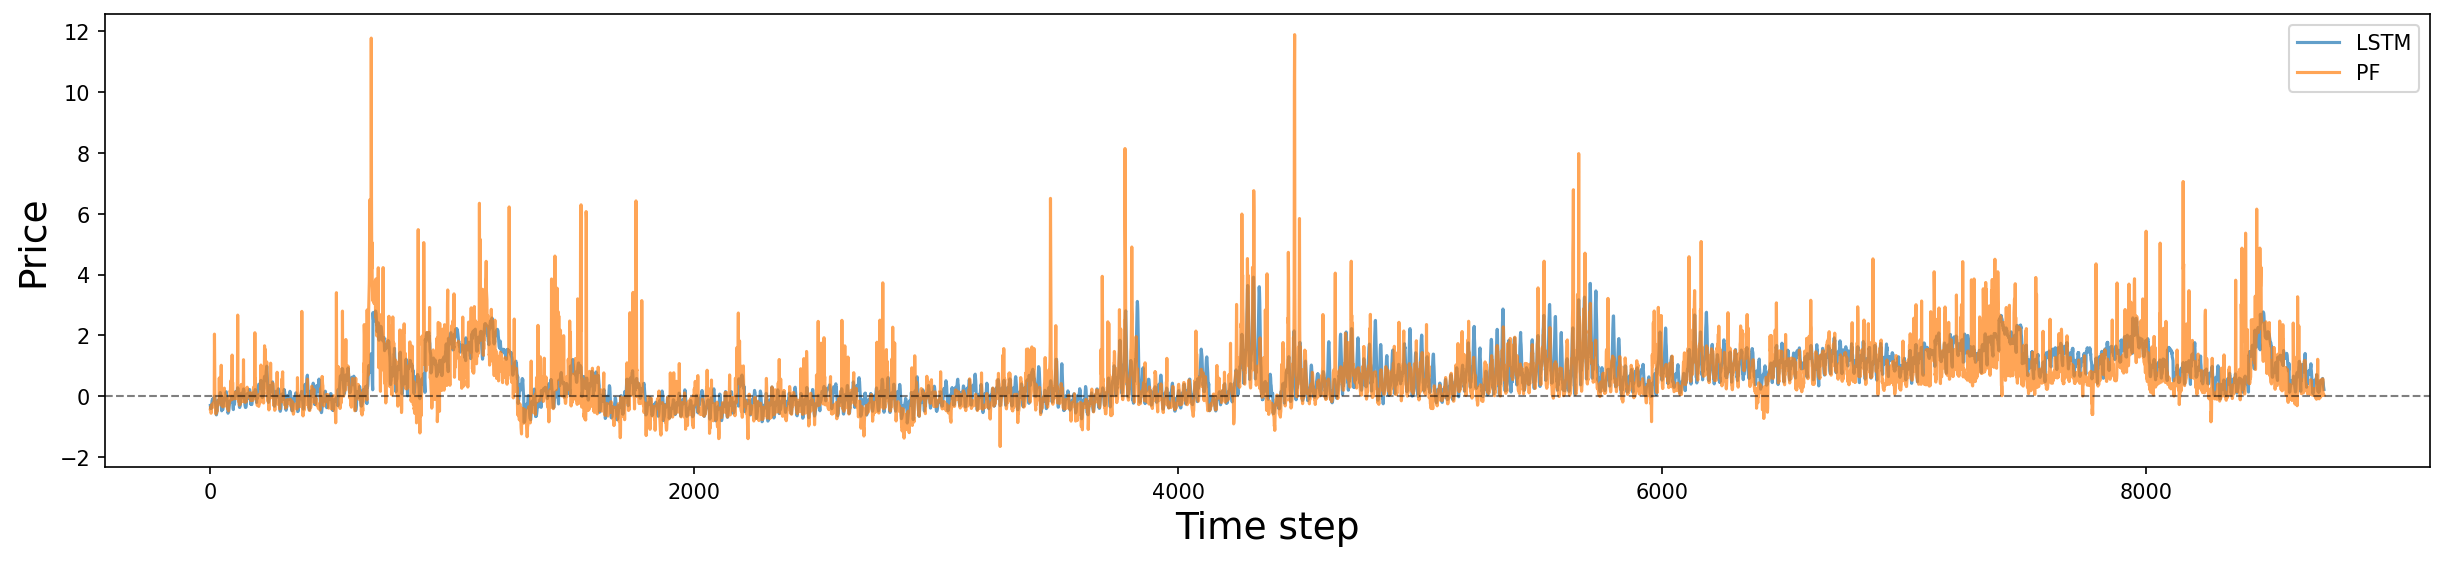

In [39]:
plot_predictions(y_test_pred[::24,:].flatten(), y_test_lstm[::24,:,0].flatten(), '')

### Rescale and evaluate performance

In [40]:
y_test_pred_rescale = y_test_pred*y_std.values + y_mean.values
y_test_lstm_rescale = y_test_lstm*y_std.values + y_mean.values

y_test_pred_invlog = np.exp(y_test_pred_rescale) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog = np.exp(y_test_lstm_rescale) -1 + min(raw_data.loc[:,"RTP"])

Hour Ahead Evaluation
MAE: 9.6158
RMSE: 18.8495
24-Hours Ahead Evaluation
MAE: 12.0463
RMSE: 22.0011


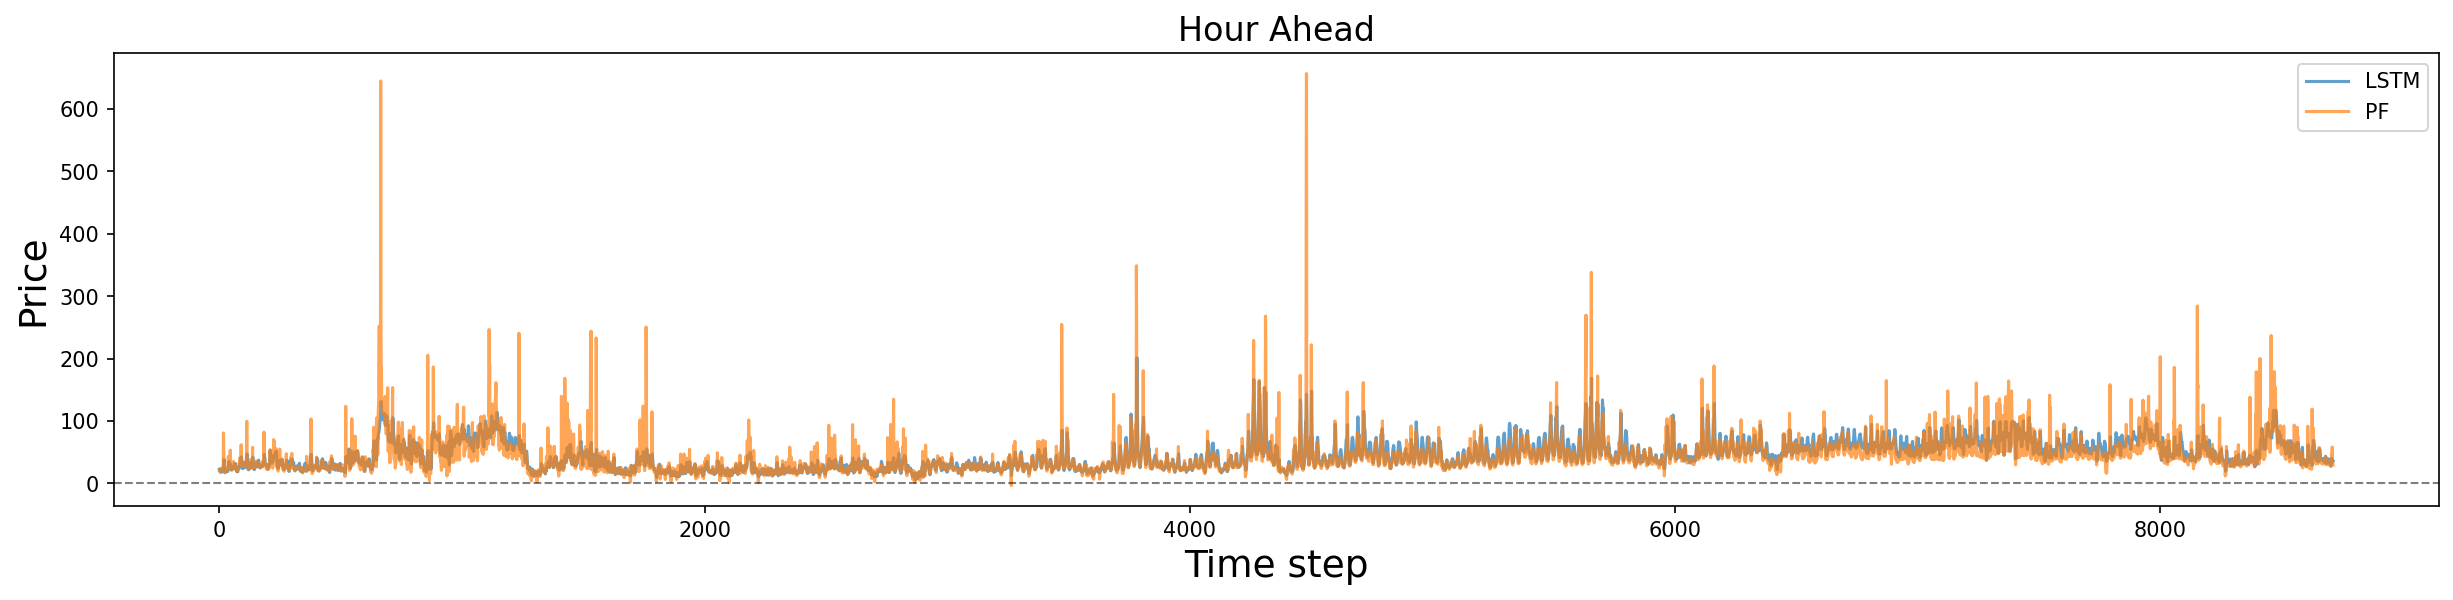

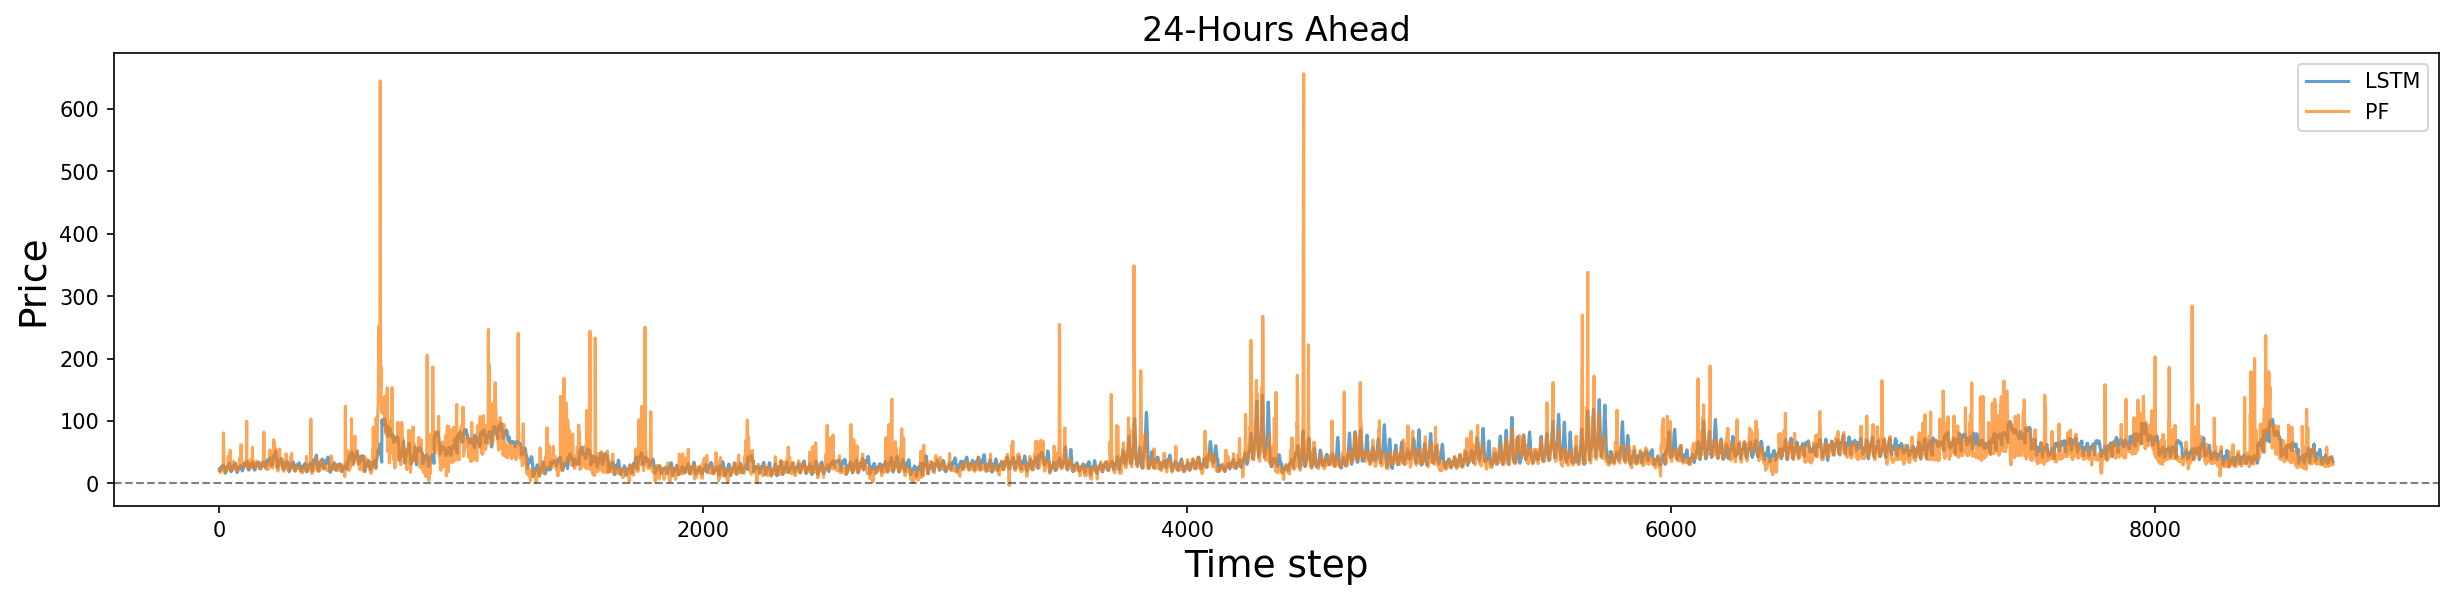

In [42]:
# Evaluation metrics
# 24 hours ahead
errors = y_test_pred_invlog[:,0] - y_test_lstm_invlog[:,0,0]
print('Hour Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

errors = y_test_pred_invlog[::24,:] - y_test_lstm_invlog[::24,:,0]
print('24-Hours Ahead Evaluation')
print('MAE: {:.4f}'.format(np.abs(errors).mean()))
print('RMSE: {:.4f}'.format(np.sqrt(np.square(errors).mean())))

plot_predictions(y_test_pred_invlog[:,0].flatten(), y_test_lstm_invlog[:,0,0].flatten(), 'Hour Ahead')
plot_predictions(y_test_pred_invlog[::24,:].flatten(), y_test_lstm_invlog[::24,:,0].flatten(), '24-Hours Ahead')


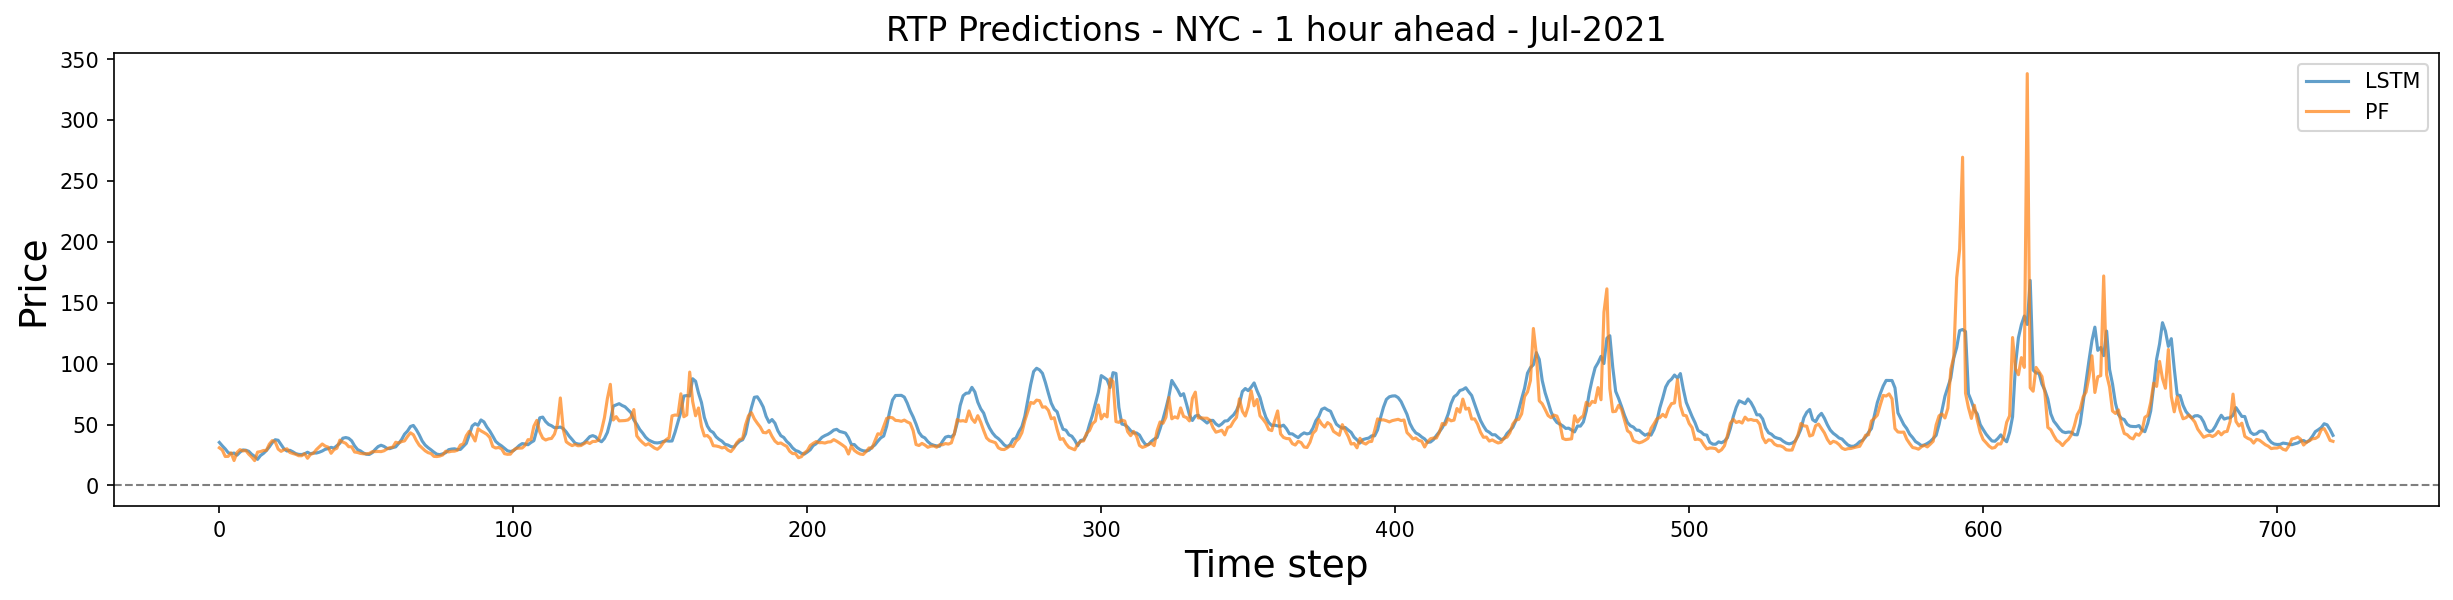

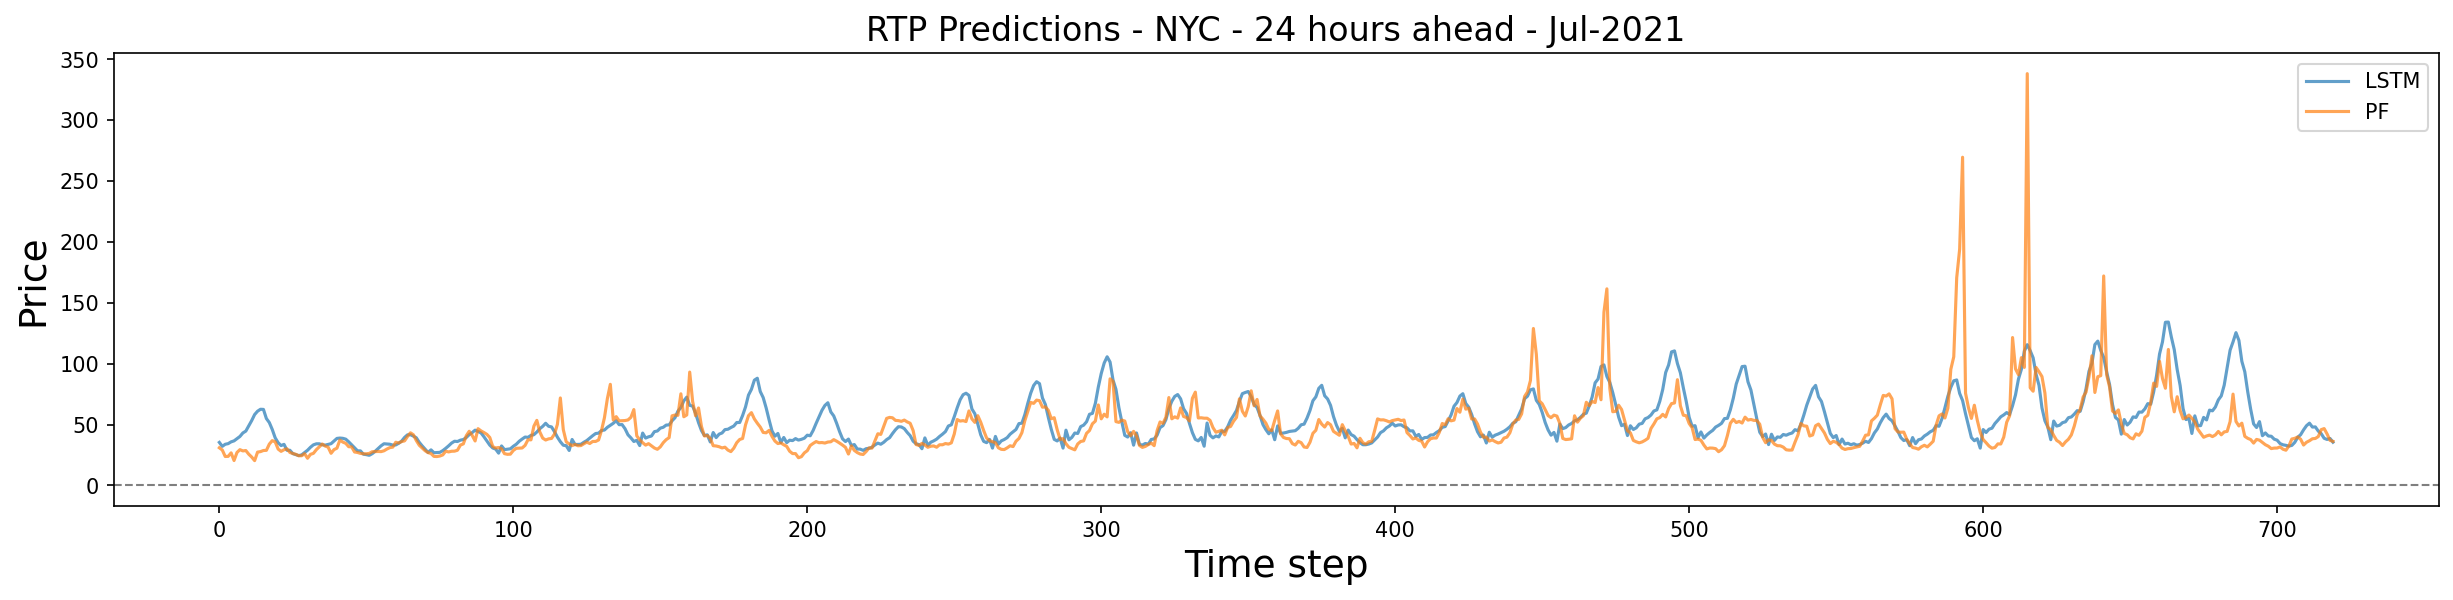

In [43]:
i = 7*24*30
j = i + 24*30

plot_predictions(y_test_pred_invlog[i:j,0].flatten(),
               y_test_lstm_invlog[i:j,0,0].flatten(),
               'RTP Predictions - NYC - 1 hour ahead - Jul-2021')

plot_predictions(y_test_pred_invlog[i:j:24,:].flatten(),
               y_test_lstm_invlog[i:j:24,:].flatten(),
               'RTP Predictions - NYC - 24 hours ahead - Jul-2021')
